In [1]:
#!pip install -r requirements.txt
import torch
from IMV_LSTM.networks import IMVTensorMultiStepLSTM
from IMV_LSTM.model_prep import prepare_multistep_data
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from models.PatchTST_Attention import Model
from data_provider.data_loader import Dataset_Custom
from evaluation.performance import stepwise_errors, get_preds_truths, evaluate
from evaluation.randomize_patchtst import (
    restore_original_attention,
    enable_attention_randomization,
    disable_attention_randomization,
    patchtst_randomization_check
)
from evaluation.randomize_imv_lstm import imvlstm_attention_randomization_check
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import os, re
from evaluation.randomize_imv_lstm import imvlstm_beta_randomization_check


# Model Training

## PatchTST

In [ ]:
%run scripts/PatchTST/weather_int.py


Running experiment with pred_len=72, logging to ./logs/LongForecasting/PatchTST_Attention_weather_int_288_72.log ...
Args in experiment:
Namespace(random_seed=2021, is_training=1, model_id='weather_int_288_72', model='PatchTST_Attention', data='custom', root_path='C:/Users/miche/Documents/PatchTST/PatchTST_supervised/dataset/', data_path='weather_int.csv', features='MS', target='T (degC)', freq='10T', checkpoints='./checkpoints/', seq_len=288, label_len=72, pred_len=72, fc_dropout=0.2, head_dropout=0.0, patch_len=24, stride=12, padding_patch='end', revin=1, affine=0, subtract_last=0, decomposition=0, kernel_size=25, individual=1, embed_type=0, enc_in=7, dec_in=7, c_out=1, d_model=140, n_heads=7, e_layers=3, d_layers=1, d_ff=560, moving_avg=25, factor=1, distil=True, dropout=0.2, embed='timeF', activation='gelu', output_attention=True, do_predict=True, num_workers=4, itr=1, train_epochs=100, batch_size=128, patience=25, learning_rate=0.0003, des='Exp', loss='mse', lradj='type3', pct_sta

In [1]:
%run scripts/PatchTST/weather_int.py

Running experiment with pred_len=72, logging to ./logs/LongForecasting/PatchTST_Attention_weather_int_288_72.log ...
Args in experiment:
Namespace(random_seed=2021, is_training=1, model_id='weather_int_288_72', model='PatchTST_Attention', data='custom', root_path='C:/Users/miche/Documents/PatchTST/PatchTST_supervised/dataset/', data_path='weather_int.csv', features='MS', target='T (degC)', freq='10T', checkpoints='./checkpoints/', seq_len=288, label_len=72, pred_len=72, fc_dropout=0.2, head_dropout=0.0, patch_len=24, stride=12, padding_patch='end', revin=1, affine=0, subtract_last=0, decomposition=0, kernel_size=25, individual=1, embed_type=0, enc_in=7, dec_in=7, c_out=1, d_model=140, n_heads=7, e_layers=3, d_layers=1, d_ff=280, moving_avg=25, factor=1, distil=True, dropout=0.2, embed='timeF', activation='gelu', output_attention=True, do_predict=True, num_workers=4, itr=1, train_epochs=100, batch_size=128, patience=14, learning_rate=0.0003, des='Exp', loss='mse', lradj='type3', pct_sta

## IMV LSTM

In [ ]:
%run scripts/IMV_LSTM/weather_int_IMV_LSTM.py \
  --root_path C:/Users/miche/Documents/PatchTST/PatchTST_supervised/dataset/ \
  --data_path weather_int.csv \
  --input_window 576 \
  --forecast_horizon 144 \
  --batch_size 128 \
  --epochs 100 \
  --lr 3e-4 \
  --patience 25 \
  --save_dir ./logs/IMV_weather


# Model Evaluation

## Loading Models from Path

### Prediction Length 10 - PatchTST

In [43]:
class Args:
    # random seed
    random_seed = 2021

    # basic config
    is_training = 0
    model_id = 'test'
    model = 'PatchTST_Attention'

    # data loader
    data = 'weather'
    root_path = './dataset'
    data_path = 'weather_int.csv'
    features = 'MS'
    target = 'T (degC)'
    freq = '10T'
    checkpoints = './checkpoints/'

    # forecasting task
    seq_len = 40
    label_len = 10
    pred_len = 10

    # PatchTST
    fc_dropout = 0.1
    head_dropout = 0.0
    patch_len = 8
    stride = 4
    padding_patch = 'end'
    revin = 1
    affine = 0
    subtract_last = 0
    decomposition = 0
    kernel_size = 25
    individual = 1  # True

    # Formers
    embed_type = 0
    enc_in = 7
    dec_in = 7
    c_out = 1
    d_model = 140
    n_heads = 7
    e_layers = 3
    d_layers = 1
    d_ff = 560
    moving_avg = 25
    factor = 1
    distil = True
    dropout = 0.1
    embed = 'timeF'
    activation = 'gelu'
    output_attention = True
    do_predict = False

    # optimization
    num_workers = 4
    itr = 1
    train_epochs = 100
    batch_size = 128
    patience = 5
    learning_rate = 0.0001
    des = 'Exp'
    loss = 'mse'
    lradj = 'type3'
    pct_start = 0.3
    use_amp = False

    # GPU
    use_gpu = True
    gpu = 0
    use_multi_gpu = False
    devices = '0,1,2,3'
    test_flop = False


args = Args()



In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt_path=(
    "checkpoints/"
    "weather_int_40_10_PatchTST"
    "/checkpoint.pth"
)
ckpt_patch = torch.load(ckpt_path, map_location=device)

state_dict_patch = ckpt_patch.get("model_state_dict", ckpt_patch)
model_patch = Model(args)
model_patch = model_patch.float().to(device)
model_patch.load_state_dict(state_dict_patch)
model_patch.eval()


Model(
  (model): PatchTST_backbone(
    (revin_layer): RevIN()
    (padding_patch_layer): ReplicationPad1d((0, 4))
    (backbone): TSTiEncoder(
      (W_P): Linear(in_features=8, out_features=140, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (encoder): TSTEncoder(
        (layers): ModuleList(
          (0): TSTEncoderLayer(
            (self_attn): _MultiheadAttention(
              (W_Q): Linear(in_features=140, out_features=140, bias=True)
              (W_K): Linear(in_features=140, out_features=140, bias=True)
              (W_V): Linear(in_features=140, out_features=140, bias=True)
              (sdp_attn): _ScaledDotProductAttention(
                (attn_dropout): Dropout(p=0.0, inplace=False)
              )
              (to_out): Sequential(
                (0): Linear(in_features=140, out_features=140, bias=True)
                (1): Dropout(p=0.1, inplace=False)
              )
            )
            (dropout_attn): Dropout(p=0.1, inplace=False)
    

In [47]:
# 1) Instantiate your test‐time dataset exactly as during training
dataset_test = Dataset_Custom(
    root_path   = "dataset/",
    flag        = "test",                 # pulls the test split
    size        = [40, 10, 10],          # [seq_len, label_len, pred_len]
    features    = "MS",
    data_path   = "weather_int.csv",
    target      = "T (degC)",
    scale       = True,
    timeenc     = 0,
    freq        = "10T",
)

# 2) Wrap in a DataLoader
test_loader_patch = DataLoader(
    dataset_test,
    batch_size  = 128,
    shuffle     = False,
    num_workers = 4,
)


### Prediction Length 10 - IMV-LSTM

In [5]:
# 1) Re-create the model with the same hyper-parameters:
model_IMV = IMVTensorMultiStepLSTM(
    input_dim     = 7,
    output_dim    = 1,
    n_units       = 140,
    forecast_steps= 10
).float().to(device)

# 2) Load the checkpoint (and automatically map to CPU/GPU):
ckpt_path_IMV = "./imv_best.pth"
state_IMV = torch.load(ckpt_path_IMV, map_location=device)
model_IMV.load_state_dict(state_IMV)

df = pd.read_csv("dataset/weather_int.csv")
target_weather= 'T (degC)'
cols_weather_multi=['p (mbar)', 'Tdew (degC)', 'sh (g/kg)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)', 'T (degC)']
input_window = 40   # instead of 40
forecast_horizon = 10
batch_size_weather=128
X_train_multi, y_train_multi, \
X_val_multi, y_val_multi, \
X_test_multi, y_test_multi, \
input_scaler_multi, target_scaler_multi = prepare_multistep_data(
    df=df,
    input_columns=cols_weather_multi,
    target_column=target_weather,
    input_window=input_window,
    forecast_horizon=forecast_horizon,
    scale_data=True
)
X_train_t_multi = torch.tensor(X_train_multi, dtype=torch.float32)
X_val_t_multi   = torch.tensor(X_val_multi, dtype=torch.float32)
X_test_t_multi  = torch.tensor(X_test_multi, dtype=torch.float32)

y_train_t_multi = torch.tensor(y_train_multi, dtype=torch.float32)
y_val_t_multi   = torch.tensor(y_val_multi, dtype=torch.float32)
y_test_t_multi  = torch.tensor(y_test_multi, dtype=torch.float32)


test_loader_IMV = DataLoader(
    TensorDataset(X_test_t_multi, y_test_t_multi),
    shuffle=False,
    batch_size=batch_size_weather
)

### Prediction Length 72 - PatchTST

In [6]:
class Args:
    # random seed
    random_seed = 2021

    # basic config
    is_training = 0
    model_id = 'test'
    model = 'PatchTST_Attention'

    # data loader
    data = 'weather'
    root_path = './dataset'
    data_path = 'weather_int.csv'
    features = 'MS'
    target = 'T (degC)'
    freq = '10T'
    checkpoints = './checkpoints/'

    # forecasting task
    seq_len = 432
    label_len = 72
    pred_len = 72

    # PatchTST
    fc_dropout = 0.2
    head_dropout = 0.0
    patch_len = 24
    stride = 12
    padding_patch = 'end'
    revin = 1
    affine = 0
    subtract_last = 0
    decomposition = 0
    kernel_size = 25
    individual = 1  # True

    # Formers
    embed_type = 0
    enc_in = 7
    dec_in = 7
    c_out = 1
    d_model = 140
    n_heads = 7
    e_layers = 3
    d_layers = 1
    d_ff = 280
    moving_avg = 25
    factor = 1
    distil = True
    dropout = 0.2
    embed = 'timeF'
    activation = 'gelu'
    output_attention = True
    do_predict = False

    # optimization
    num_workers = 4
    itr = 1
    train_epochs = 100
    batch_size = 128
    patience = 5
    learning_rate = 0.0003
    des = 'Exp'
    loss = 'mse'
    lradj = 'type3'
    pct_start = 0.3
    use_amp = False

    # GPU
    use_gpu = True
    gpu = 0
    use_multi_gpu = False
    devices = '0,1,2,3'
    test_flop = False


args_mid = Args()



In [8]:
import os
import torch

# 1) Set device and paths
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt_dir_mid  = (
    "checkpoints/"
    "weather_int_432_72_PatchTST"
)
ckpt_path_mid = os.path.join(ckpt_dir_mid, "checkpoint.pth")  # or checkpoint_latest.pth

# sanity check
assert os.path.isfile(ckpt_path_mid), f"Checkpoint not found: {ckpt_path_mid}"

# 2) Load the checkpoint
ckpt_mid = torch.load(ckpt_path_mid, map_location=device)

# 3) Extract the state dict (fallback to the whole object if it isn’t a dict)
state_dict_patch_mid = ckpt_mid.get("model_state", ckpt_mid)

# 4) Rebuild & load your model
model_patch_mid = Model(args_mid).to(device).float()
model_patch_mid.load_state_dict(state_dict_patch_mid)
model_patch_mid.eval()

Model(
  (model): PatchTST_backbone(
    (revin_layer): RevIN()
    (padding_patch_layer): ReplicationPad1d((0, 12))
    (backbone): TSTiEncoder(
      (W_P): Linear(in_features=24, out_features=140, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (encoder): TSTEncoder(
        (layers): ModuleList(
          (0): TSTEncoderLayer(
            (self_attn): _MultiheadAttention(
              (W_Q): Linear(in_features=140, out_features=140, bias=True)
              (W_K): Linear(in_features=140, out_features=140, bias=True)
              (W_V): Linear(in_features=140, out_features=140, bias=True)
              (sdp_attn): _ScaledDotProductAttention(
                (attn_dropout): Dropout(p=0.0, inplace=False)
              )
              (to_out): Sequential(
                (0): Linear(in_features=140, out_features=140, bias=True)
                (1): Dropout(p=0.2, inplace=False)
              )
            )
            (dropout_attn): Dropout(p=0.2, inplace=False)
  

In [32]:
# 1) Instantiate your test‐time dataset exactly as during training
dataset_test_patch_mid = Dataset_Custom(
    root_path   = "dataset/",
    flag        = "test",                 # pulls the test split
    size        = [432, 72, 72],          # [seq_len, label_len, pred_len]
    features    = "MS",
    data_path   = "weather_int.csv",
    target      = "T (degC)",
    scale       = True,
    timeenc     = 0,
    freq        = "10T",
)

# 2) Wrap in a DataLoader
test_loader_patch_mid = DataLoader(
    dataset_test_mid,
    batch_size  = 128,
    shuffle     = False,
    num_workers = 4,
)


### Prediction Length 72 - IMV-LSTM 

In [23]:
# 1) Re-create the model with the same hyper-parameters:
model_IMV_mid = IMVTensorMultiStepLSTM(
    input_dim     = 7,
    output_dim    = 1,
    n_units       = 140,
    forecast_steps= 72
).float().to(device)

# 2) Load the checkpoint (and automatically map to CPU/GPU):
ckpt_path_IMV_mid = "./IMV_weather_432_72/attention_val/checkpoint_latest.pth"
state_IMV_mid = torch.load(ckpt_path_IMV_mid, map_location=device)
model_IMV_mid.load_state_dict(state_IMV_mid['model_state'])

df = pd.read_csv("dataset/weather_int.csv")
target_weather= 'T (degC)'
cols_weather_multi=['p (mbar)', 'Tdew (degC)', 'sh (g/kg)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)', 'T (degC)']
input_window_mid = 432   # instead of 40
forecast_horizon_mid = 72
batch_size_weather=128
X_train_mid, y_train_mid, \
X_val_mid, y_val_mid, \
X_test_mid, y_test_mid, \
input_scaler_mid, target_scaler_mid = prepare_multistep_data(
    df=df,
    input_columns=cols_weather_multi,
    target_column=target_weather,
    input_window=input_window_mid,
    forecast_horizon=forecast_horizon_mid,
    scale_data=True
)
X_train_t_mid = torch.tensor(X_train_mid, dtype=torch.float32)
X_val_t_mid   = torch.tensor(X_val_mid, dtype=torch.float32)
X_test_t_mid  = torch.tensor(X_test_mid, dtype=torch.float32)

y_train_t_mid = torch.tensor(y_train_mid, dtype=torch.float32)
y_val_t_mid   = torch.tensor(y_val_mid, dtype=torch.float32)
y_test_t_mid  = torch.tensor(y_test_mid, dtype=torch.float32)


test_loader_IMV_mid = DataLoader(
    TensorDataset(X_test_t_mid, y_test_t_mid),
    shuffle=False,
    batch_size=batch_size_weather
)

### Prediction Length 144 - PatchTST

In [11]:
class Args:
    # random seed
    random_seed = 2021

    # basic config
    is_training = 0
    model_id = 'weather_int'
    model = 'PatchTST_Attention'

    # data loader
    data = 'custom'
    root_path = './dataset'
    data_path = 'weather_int.csv'
    features = 'MS'
    target = 'T (degC)'
    freq = '10T'
    checkpoints = './checkpoints/'

    # forecasting task
    seq_len = 576     # 4 days of history (576 × 10 min)
    label_len = 144   # decoder sees last 1 day (144 steps)
    pred_len = 144    # forecast horizon = 1 day

    # PatchTST-specific
    fc_dropout = 0.2
    head_dropout = 0.0
    patch_len = 24    # 4 h patches (24 × 10 min)
    stride = 12       # 50% overlap
    padding_patch = 'end'
    revin = 1
    affine = 0
    subtract_last = 0
    decomposition = 0
    kernel_size = 25
    individual = 1  # True

    # Transformer backbone
    embed_type = 0
    enc_in = 7
    dec_in = 7
    c_out = 1
    d_model = 70
    n_heads = 7
    e_layers = 3
    d_layers = 1
    d_ff = 280
    moving_avg = 25
    factor = 1
    distil = True
    dropout = 0.2
    embed = 'timeF'
    activation = 'gelu'
    output_attention = True
    do_predict = False

    # optimization
    num_workers = 4
    itr = 1
    train_epochs = 100
    batch_size = 128
    patience = 25
    learning_rate = 1e-4
    des = 'Exp'
    loss = 'mse'
    lradj = 'type3'
    pct_start = 0.3
    use_amp = False

    # GPU
    use_gpu = True
    gpu = 0
    use_multi_gpu = False
    devices = '0'
    test_flop = False

args_long = Args()


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt_path_long=(
    "checkpoints/"
    "weather_int_576_144_PatchTST_Attention_custom_ftMS_sl576_ll144_pl144_dm70_nh7_el3_dl1_df280_fc1_ebtimeF_dtTrue_Exp_0"
    "/checkpoint.pth"
)

ckpt_patch_long = torch.load(ckpt_path_long, map_location=device)

state_dict_patch_long = ckpt_patch_long.get("model_state_dict", ckpt_patch_long)
model_patch_long = Model(args_long)
model_patch_long = model_patch_long.float().to(device)
model_patch_long.load_state_dict(state_dict_patch_long)
model_patch_long.eval()


Model(
  (model): PatchTST_backbone(
    (revin_layer): RevIN()
    (padding_patch_layer): ReplicationPad1d((0, 12))
    (backbone): TSTiEncoder(
      (W_P): Linear(in_features=24, out_features=70, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (encoder): TSTEncoder(
        (layers): ModuleList(
          (0): TSTEncoderLayer(
            (self_attn): _MultiheadAttention(
              (W_Q): Linear(in_features=70, out_features=70, bias=True)
              (W_K): Linear(in_features=70, out_features=70, bias=True)
              (W_V): Linear(in_features=70, out_features=70, bias=True)
              (sdp_attn): _ScaledDotProductAttention(
                (attn_dropout): Dropout(p=0.0, inplace=False)
              )
              (to_out): Sequential(
                (0): Linear(in_features=70, out_features=70, bias=True)
                (1): Dropout(p=0.2, inplace=False)
              )
            )
            (dropout_attn): Dropout(p=0.2, inplace=False)
           

In [13]:
# 1) Instantiate your long-horizon test dataset exactly as during training
dataset_test_patch_long = Dataset_Custom(
    root_path   = "dataset/",           # relative to cwd
    flag        = "test",               # pulls the test split
    size        = [576, 144, 144],      # [seq_len, label_len, pred_len]
    features    = "MS",
    data_path   = "weather_int.csv",
    target      = "T (degC)",
    scale       = True,
    timeenc     = 0,
    freq        = "10T",
)

# 2) Wrap in a DataLoader
test_loader_patch_long = DataLoader(
    dataset_test_patch_long,
    batch_size  = 128,
    shuffle     = False,
    num_workers = 4,
)


### Prediction Length 144 - IMV-LSTM

In [14]:
# 1) Re-create your long-horizon IMV‐LSTM model
model_IMV_long = IMVTensorMultiStepLSTM(
    input_dim      = 7,
    output_dim     = 1,
    n_units        = 140,
    forecast_steps = 144        # forecast_horizon_long
).float().to(device)

# 2) Load the long-horizon checkpoint
ckpt_path_IMV_long = "./IMV_weather_576_144/attention_val/checkpoint_latest.pth"
state_IMV_long= torch.load(ckpt_path_IMV_long, map_location=device)
model_IMV_long.load_state_dict(state_IMV_long['model_state'])

# 3) Prepare your data for the long run
df = pd.read_csv("dataset/weather_int.csv")
target_weather      = 'T (degC)'
cols_weather_multi  = [
    'p (mbar)', 'Tdew (degC)', 'sh (g/kg)',
    'wv (m/s)', 'max. wv (m/s)', 'wd (deg)', 'T (degC)'
]
input_window_long     = 576   # e.g. 4 days of history (576×10 min)
forecast_horizon_long = 144   # 1 day ahead (144×10 min)
batch_size_weather    = 128

X_train_long, y_train_long, \
X_val_long,   y_val_long,   \
X_test_long,  y_test_long,  \
in_scaler_long, out_scaler_long = prepare_multistep_data(
    df=df,
    input_columns = cols_weather_multi,
    target_column = target_weather,
    input_window  = input_window_long,
    forecast_horizon = forecast_horizon_long,
    scale_data    = True
)

# 4) Tensor‐ify
X_test_t_long = torch.tensor(X_test_long, dtype=torch.float32)
y_test_t_long = torch.tensor(y_test_long, dtype=torch.float32)

# 5) Long‐horizon test DataLoader
test_loader_IMV_long = DataLoader(
    TensorDataset(X_test_t_long, y_test_t_long),
    shuffle     = False,
    batch_size  = batch_size_weather,
    num_workers = 4
)


### Scaler

In [15]:
# Extract only the target column (same as in your dataset)
df = pd.read_csv("dataset/weather_int.csv")
target = 'T (degC)'
data = df[[target]].values

# Match train split logic (70% of total rows)
num_train = int(len(data) * 0.7)
train_data = data[:num_train]

# Recreate and fit the scaler
scaler = StandardScaler()
scaler.fit(train_data)


StandardScaler()

## Results

### MSE, RMSE, MAE

In [16]:
# ── 8) RUN & DISPLAY ─────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import evaluation.performance as perf
perf.device = device
results = []
for name, mdl, loader in [
    ("PatchTST",           model_patch,      test_loader_patch),
    ("PatchTST-Mid",       model_patch_mid,  test_loader_patch_mid),
    ("PatchTST-Long",      model_patch_long, test_loader_patch_long),
    ("IMV-LSTM",           model_IMV,        test_loader_IMV),
    ("IMV-LSTM-Mid",       model_IMV_mid,    test_loader_IMV_mid),
    ("IMV-LSTM-Long",      model_IMV_long,   test_loader_IMV_long),
]:
    metrics = evaluate(mdl, loader, target_channel=-1,scaler=None)
    metrics["Model"] = name
    results.append(metrics)

df = pd.DataFrame(results)
print(df.to_markdown(index=False))

|        MSE |      RMSE |       MAE | Model         |
|-----------:|----------:|----------:|:--------------|
| 0.00564983 | 0.0751654 | 0.0496927 | PatchTST      |
| 0.0593334  | 0.243585  | 0.176785  | PatchTST-Mid  |
| 0.0963018  | 0.310325  | 0.228361  | PatchTST-Long |
| 0.239846   | 0.489741  | 0.417305  | IMV-LSTM      |
| 0.148076   | 0.384806  | 0.29161   | IMV-LSTM-Mid  |
| 0.307852   | 0.554844  | 0.461634  | IMV-LSTM-Long |


PatchTST massively outperforms the LSTM

For the short‐horizon task, PatchTST’s RMSE is ~0.075 std vs the LSTM’s ~0.49 std—a > 80 % error reduction.

Even at the long horizon, PatchTST-Long’s RMSE (~0.31) is ~44 % lower than IMV-LSTM-Long (~0.55).

Forecast error grows with horizon

Both models see their RMSE jump by 3–4× when moving from the short (10‐step) to the long (144‐step) forecast.

PatchTST: RMSE from 0.075 → 0.31; IMV‐LSTM: 0.49 → 0.55 (the LSTM degrades less proportionally, but starts from a much higher baseline).

Absolute scaled errors

On scaled data (unit‐variance), PatchTST-Long’s error of ~0.31 std means on average it’s within ~0.3 standard‐deviations of the true value one day ahead. That’s quite good for a 144‐step forecast.

The LSTM’s error (~0.55 std) suggests it’s struggling to capture day‐ahead dynamics.

MAE and MSE tell the same story

MAE (mean absolute error) trends mirror RMSE: PatchTST-Long’s ~0.23 vs LSTM-Long’s ~0.46.

Bottom line:
Your transformer‐based PatchTST model is substantially more accurate than the multivariate LSTM, and as expected, both models’ accuracy degrades for longer forecasts. If you need day‐ahead weather predictions, PatchTST is clearly the stronger choice here.

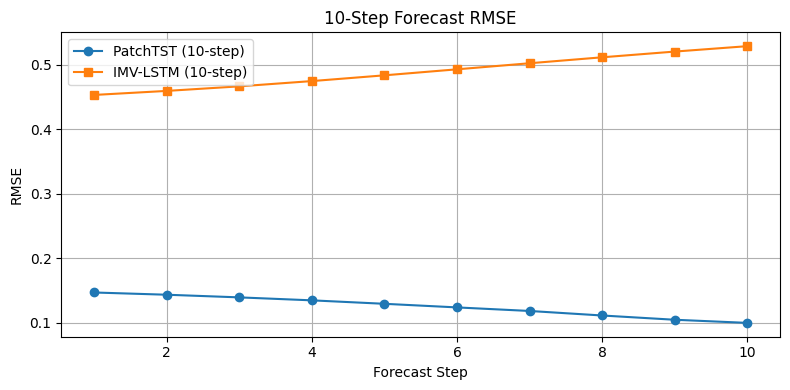

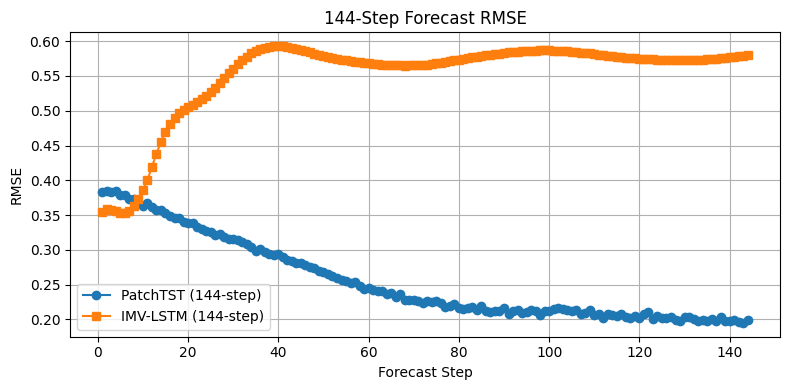

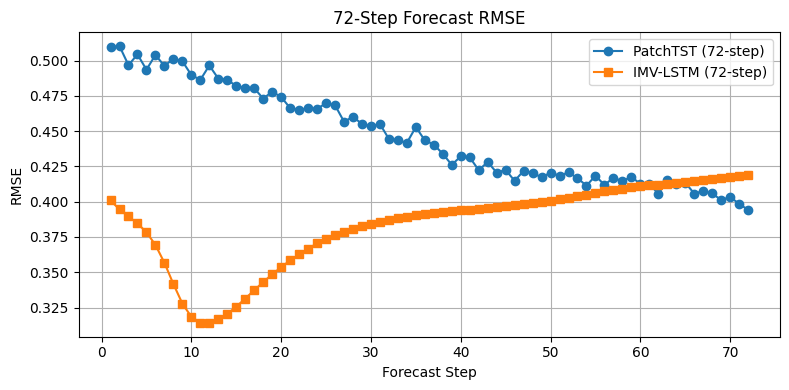

In [17]:
from evaluation.performance import get_preds_truths
from evaluation.performance     import stepwise_errors

# 1) Get preds & trues for every model / horizon
patch_preds,      patch_trues      = get_preds_truths(model_patch,      test_loader_patch,      device)
patch_preds_mid,  patch_trues_mid  = get_preds_truths(model_patch_mid,  test_loader_patch_mid,  device)
patch_preds_long, patch_trues_long = get_preds_truths(model_patch_long, test_loader_patch_long, device)

imv_preds,        imv_trues        = get_preds_truths(model_IMV,        test_loader_IMV,        device)
imv_preds_mid,    imv_trues_mid    = get_preds_truths(model_IMV_mid,    test_loader_IMV_mid,    device)
imv_preds_long,   imv_trues_long   = get_preds_truths(model_IMV_long,   test_loader_IMV_long,   device)

# 2) Now compute per-step RMSE/MAE
patch_rmse,      patch_mae      = stepwise_errors(patch_preds,      patch_trues)
patch_rmse_mid,  patch_mae_mid  = stepwise_errors(patch_preds_mid,  patch_trues_mid)
patch_rmse_long, patch_mae_long = stepwise_errors(patch_preds_long, patch_trues_long)

imv_rmse,        imv_mae        = stepwise_errors(imv_preds,        imv_trues)
imv_rmse_mid,    imv_mae_mid    = stepwise_errors(imv_preds_mid,    imv_trues_mid)
imv_rmse_long,   imv_mae_long   = stepwise_errors(imv_preds_long,   imv_trues_long)


# 2) Short‐horizon plot (pred_len=10)
steps_short = np.arange(1, len(patch_rmse) + 1)

plt.figure(figsize=(8,4))
plt.plot(steps_short, patch_rmse, marker='o', label='PatchTST (10-step)')
plt.plot(steps_short, imv_rmse,   marker='s', label='IMV-LSTM (10-step)')
plt.xlabel('Forecast Step')
plt.ylabel('RMSE')
plt.title('10-Step Forecast RMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) Long‐horizon plot (pred_len=144)
steps_long = np.arange(1, len(patch_rmse_long) + 1)

plt.figure(figsize=(8,4))
plt.plot(steps_long, patch_rmse_long, marker='o', label='PatchTST (144-step)')
plt.plot(steps_long, imv_rmse_long,   marker='s', label='IMV-LSTM (144-step)')
plt.xlabel('Forecast Step')
plt.ylabel('RMSE')
plt.title('144-Step Forecast RMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4) Mid-horizon plot (pred_len=72)
steps_mid = np.arange(1, len(patch_rmse_mid) + 1)

plt.figure(figsize=(8,4))
plt.plot(steps_mid, patch_rmse_mid, marker='o', label='PatchTST (72-step)')
plt.plot(steps_mid, imv_rmse_mid,   marker='s', label='IMV-LSTM (72-step)')
plt.xlabel('Forecast Step')
plt.ylabel('RMSE')
plt.title('72-Step Forecast RMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


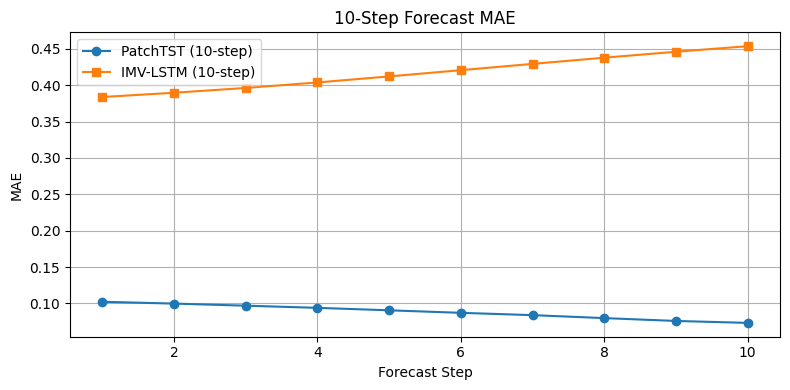

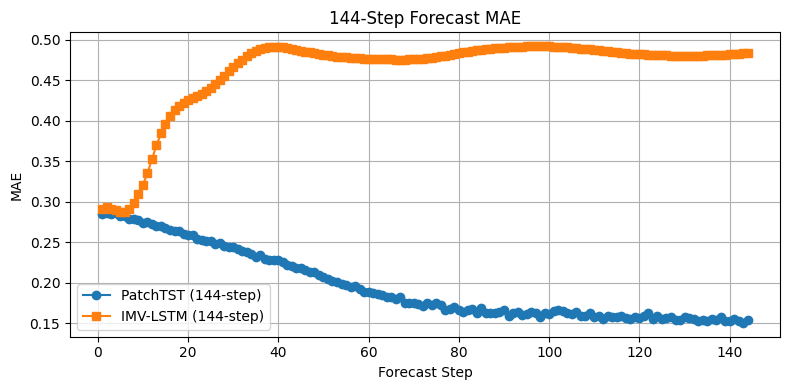

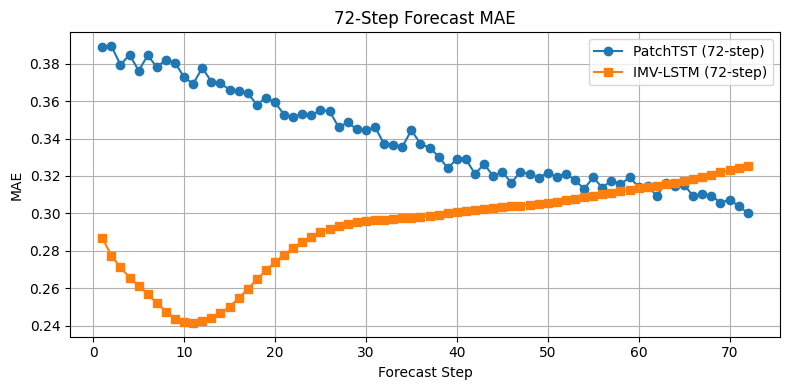

In [18]:

# 2) Short‐horizon plot (pred_len=10)
steps_short = np.arange(1, len(patch_mae) + 1)

plt.figure(figsize=(8,4))
plt.plot(steps_short, patch_mae, marker='o', label='PatchTST (10-step)')
plt.plot(steps_short, imv_mae,   marker='s', label='IMV-LSTM (10-step)')
plt.xlabel('Forecast Step')
plt.ylabel('MAE')
plt.title('10-Step Forecast MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) Long‐horizon plot (pred_len=144)
steps_long = np.arange(1, len(patch_mae_long) + 1)

plt.figure(figsize=(8,4))
plt.plot(steps_long, patch_mae_long, marker='o', label='PatchTST (144-step)')
plt.plot(steps_long, imv_mae_long,   marker='s', label='IMV-LSTM (144-step)')
plt.xlabel('Forecast Step')
plt.ylabel('MAE')
plt.title('144-Step Forecast MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4) Mid‐horizon plot (pred_len=72)
steps_mid = np.arange(1, len(patch_mae_mid) + 1)

plt.figure(figsize=(8,4))
plt.plot(steps_mid, patch_mae_mid, marker='o', label='PatchTST (72-step)')
plt.plot(steps_mid, imv_mae_mid,   marker='s', label='IMV-LSTM (72-step)')
plt.xlabel('Forecast Step')
plt.ylabel('MAE')
plt.title('72-Step Forecast MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [26]:
# say you did:
rmse_mid_list, mae_mid_list = stepwise_errors(patch_preds_mid, patch_trues_mid)  

# 1) final‐step
print("PatchTST-Mid RMSE @ step 72:", rmse_mid_list[-1])

# 2) overall (should ~0.255)
import numpy as np
overall_rmse_mid = np.sqrt(np.mean(np.array(rmse_mid_list)**2))
print("PatchTST-Mid overall RMSE:", overall_rmse_mid)


PatchTST-Mid RMSE @ step 72: 0.40041877833685185
PatchTST-Mid overall RMSE: 0.45187650842753413


In [27]:
# 1) Get the per‐step RMSE list for your mid-horizon IMV‐LSTM
imv_rmse_mid_list, imv_mae_mid_list = stepwise_errors(imv_preds_mid, imv_trues_mid)

# 2) RMSE at the final (72nd) step
print("IMV-LSTM-Mid RMSE @ step 72:", imv_rmse_mid_list[-1])

# 3) Overall RMSE (i.e. sqrt of mean squared per‐step RMSE)
import numpy as np
overall_imv_mid = np.sqrt(np.mean(np.array(imv_rmse_mid_list)**2))
print("IMV-LSTM-Mid overall RMSE:", overall_imv_mid)


IMV-LSTM-Mid RMSE @ step 72: 0.40273403016009957
IMV-LSTM-Mid overall RMSE: 0.32808760537620607


### Attention Plots

In [52]:
#%cd C:\Users\miche\Documents\XAI\PatchTST_supervised

C:\Users\miche\Documents\XAI\PatchTST_supervised


In [56]:
import os
# List all IMV_weather* folders in your CWD
for d in os.listdir():
    if d.startswith("IMV_weather_"):
        print(d)


IMV_weather_336_10
IMV_weather_576_144


In [55]:


for name, path in attn_dirs.items():
    print(f"\n[{name}] → {path}")
    if os.path.isdir(path):
        files = os.listdir(path)
        print(f"  Contains {len(files)} entries, e.g.:")
        for fn in files[:10]:
            print("   ", fn)
    else:
        print("  ✗ Directory not found")



[PatchTST_short] → test_results/weather_int_288_72_PatchTST_Attention_custom_ftMS_sl288_ll72_pl72_dm70_nh7_el3_dl1_df280_fc1_ebtimeF_dtTrue_Exp_0/attn_maps
  Contains 811 entries, e.g.:
    attn_batch_0_layer_0.npy
    attn_batch_0_layer_0_head_0.png
    attn_batch_0_layer_0_head_1.png
    attn_batch_0_layer_1.npy
    attn_batch_0_layer_1_head_0.png
    attn_batch_0_layer_1_head_1.png
    attn_batch_0_layer_2.npy
    attn_batch_0_layer_2_head_0.png
    attn_batch_0_layer_2_head_1.png
    attn_batch_10_layer_0.npy

[PatchTST_long] → test_results/weather_int_576_144_PatchTST_Attention_custom_ftMS_sl576_ll144_pl144_dm70_nh7_el3_dl1_df280_fc1_ebtimeF_dtTrue_Exp_0/attn_maps
  Contains 810 entries, e.g.:
    attn_batch_0_layer_0.npy
    attn_batch_0_layer_0_head_0.png
    attn_batch_0_layer_0_head_1.png
    attn_batch_0_layer_1.npy
    attn_batch_0_layer_1_head_0.png
    attn_batch_0_layer_1_head_1.png
    attn_batch_0_layer_2.npy
    attn_batch_0_layer_2_head_0.png
    attn_batch_0_layer_2

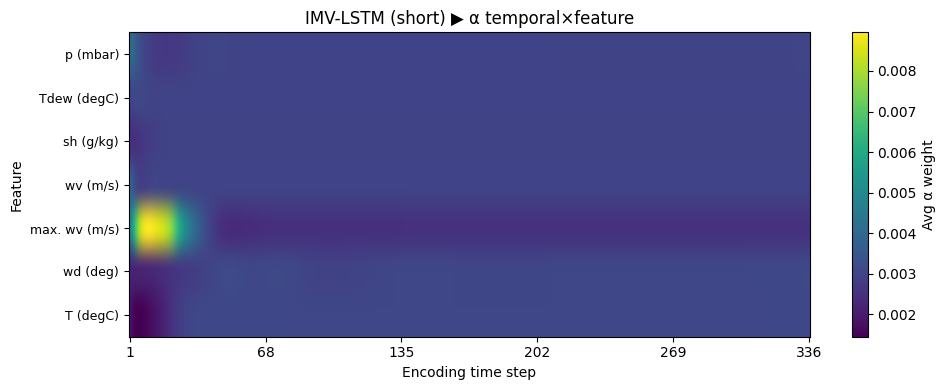

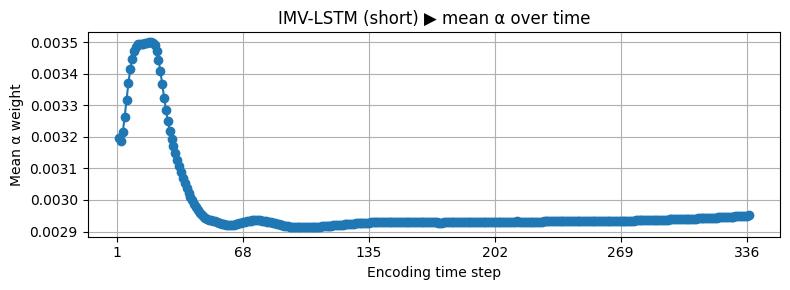

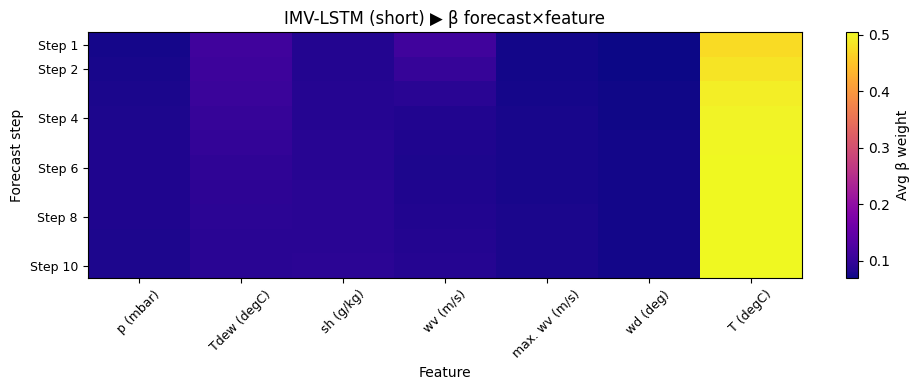

In [14]:
# 1) Re-define your feature list
from evaluation.attention_plots import plot_imv_saved_attention
cols_weather_multi = [
    'p (mbar)', 'Tdew (degC)', 'sh (g/kg)',
    'wv (m/s)', 'max. wv (m/s)', 'wd (deg)',
    'T (degC)'
]



# 3) IMV-LSTM “short” attention plots
plot_imv_saved_attention(
    attn_dir      = "IMV_weather_336_10/imv_attention_test",
    seq_len       = 336,
    pred_len      = 10,
    feature_names = cols_weather_multi,
    run_name      = "short"
)

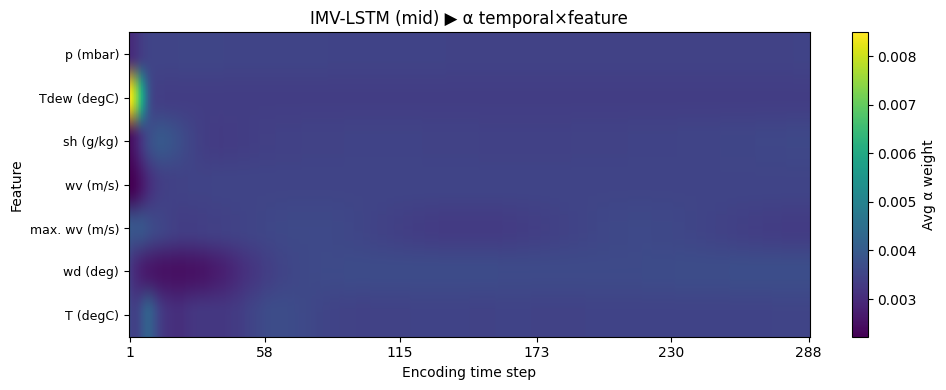

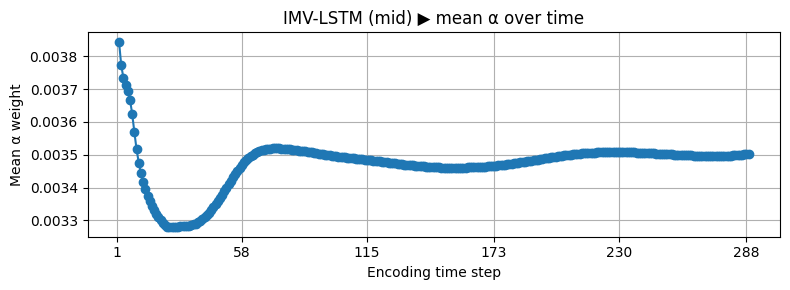

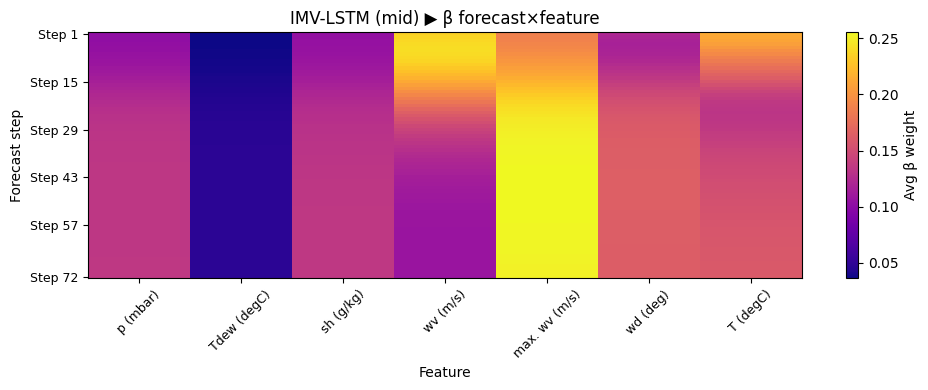

In [15]:
plot_imv_saved_attention(
    attn_dir      = "IMV_weather_288_72/attention_test",
    seq_len       = 288,
    pred_len      = 72,
    feature_names = cols_weather_multi,
    run_name      = "mid"
)

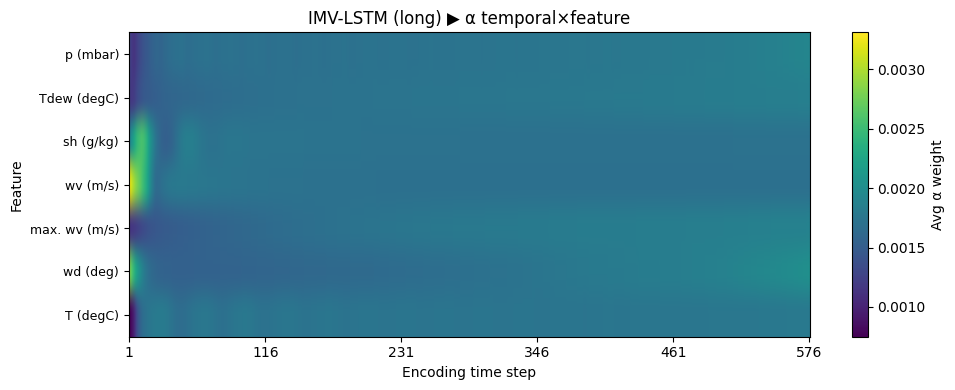

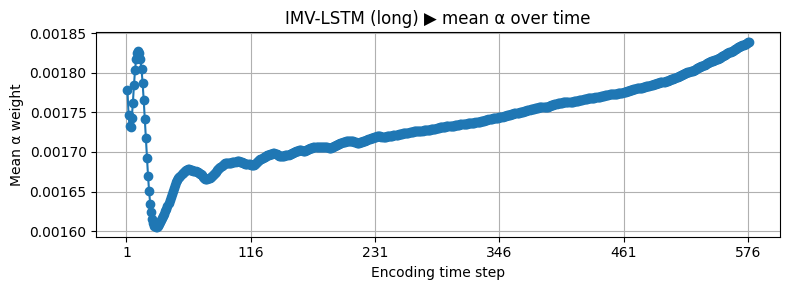

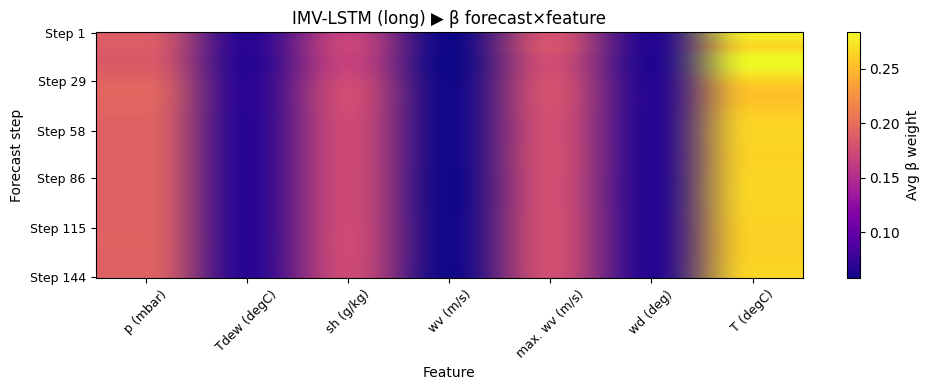

In [16]:
plot_imv_saved_attention(
    attn_dir      = "IMV_weather_576_144/attention_test",
    seq_len       = 576,
    pred_len      = 144,
    feature_names = cols_weather_multi,
    run_name      = "long"
)


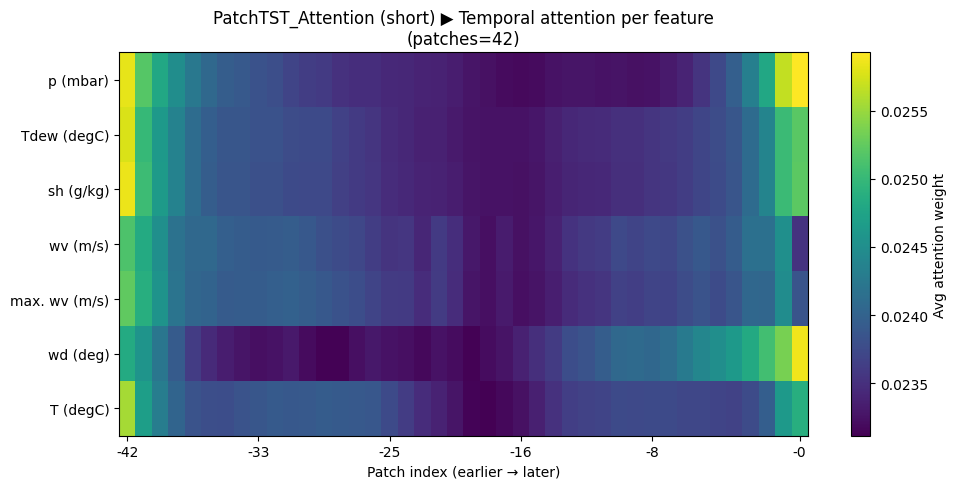

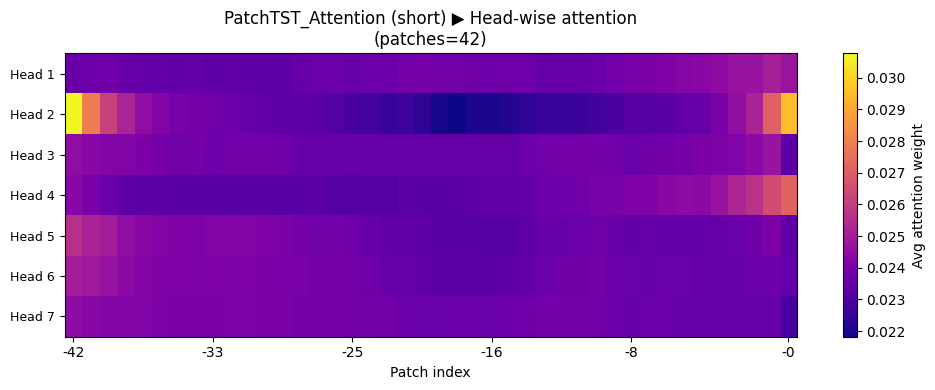

In [19]:
plot_patchtst_temporal(
    attn_dir    = "test_results/weather_int_336_10_PatchTST_Attention_custom_ftMS_sl336_ll10_pl10_dm70_nh7_el3_dl1_df280_fc1_ebtimeF_dtTrue_Exp_0/attn_maps",
    num_layers  = 3,
    num_batches = 81,                       # your batch count
    num_vars    = len(cols_weather_multi),  # 7
    num_heads   = 7,
    feature_names = cols_weather_multi,
    model_name    = "PatchTST_Attention",
    run_name      = "short"
)


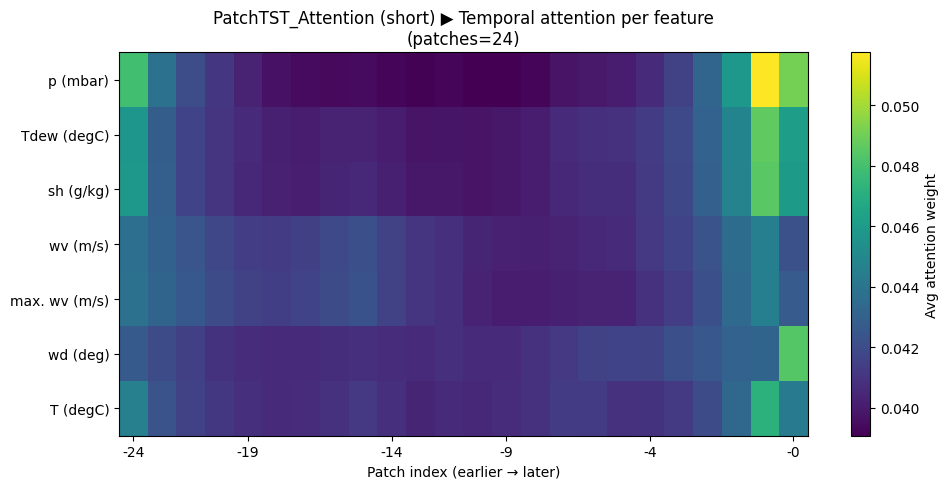

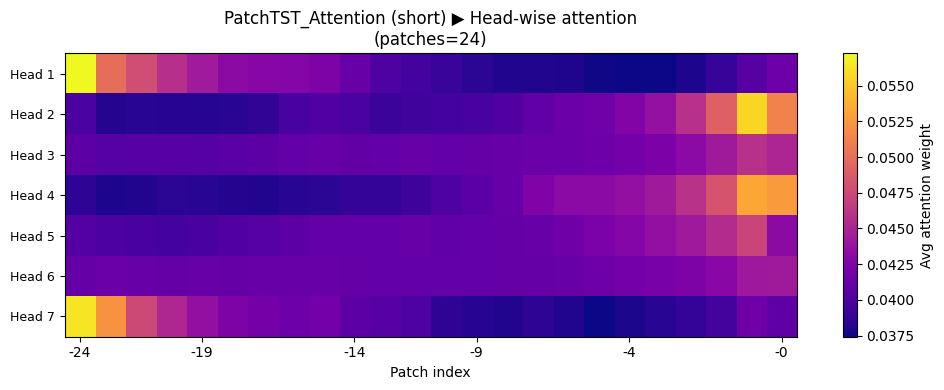

In [17]:
from evaluation.attention_plots import plot_patchtst_temporal

plot_patchtst_temporal(
    attn_dir    = "test_results/weather_int_288_72_PatchTST/attn_maps",
    num_layers  = 3,
    num_batches = 81,                       # your batch count
    num_vars    = len(cols_weather_multi),  # 7
    num_heads   = 7,
    feature_names = cols_weather_multi,
    model_name    = "PatchTST_Attention",
    run_name      = "mid"
)


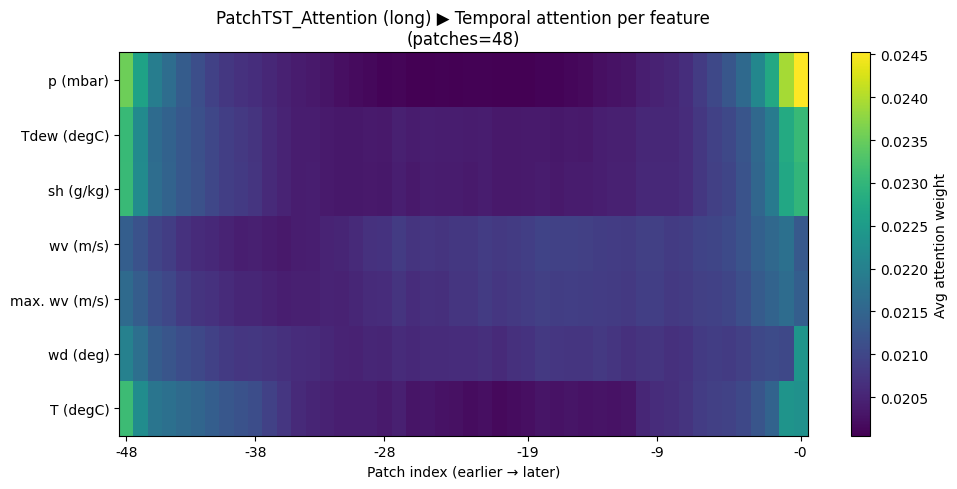

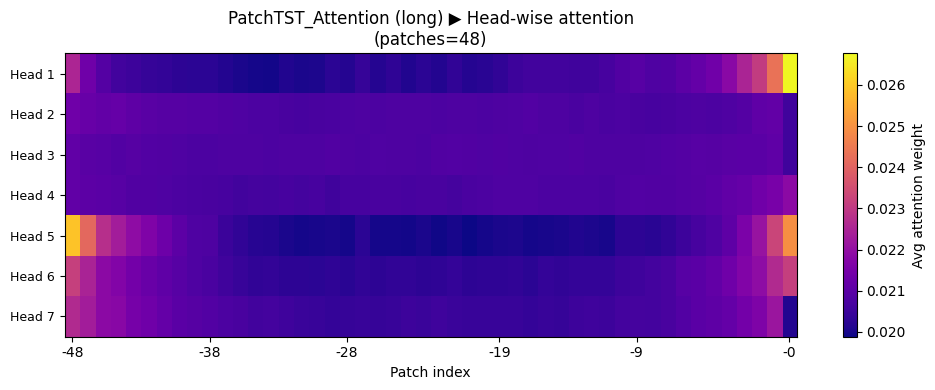

In [18]:
# 4) And for your “long” run (just swap to the long paths & lengths):
plot_patchtst_temporal(
    attn_dir      = "test_results/weather_int_576_144_PatchTST_Attention_custom_ftMS_sl576_ll144_pl144_dm70_nh7_el3_dl1_df280_fc1_ebtimeF_dtTrue_Exp_0/attn_maps",
    num_layers  = 3,
    num_batches = 81,                       # your batch count
    num_vars    = len(cols_weather_multi),  # 7
    num_heads   = 7,
    feature_names = cols_weather_multi,
    model_name    = "PatchTST_Attention",
    run_name      = "long"
)

### Randomisation PatchTST

In [80]:
# List out your two runs
restore_original_attention()

# 1) quick smoke check on one batch of the short model
xb, yb, *_ = next(iter(test_loader_patch))
xb = xb.to(device).float()
with torch.no_grad():
    out = model_patch(xb)
print("baseline short out shape:", out.shape)

enable_attention_randomization()
with torch.no_grad():
    out_r = model_patch(xb)
print("rand-attn short out shape:", out_r.shape)
disable_attention_randomization()

# 2) run full randomization tests on both
for name, m, loader, pred_len in [
    ("PatchTST-Short", model_patch,      test_loader_patch,      10),
    ("PatchTST-Long",  model_patch_long, test_loader_patch_long, 144),
]:
    print(f"\n=== {name} ===")
    orig_mse, rand_mse = patchtst_randomization_check(
        m, loader, device, pred_len=pred_len
    )
    print(f"orig MSE = {orig_mse:.4f}, rand MSE = {rand_mse:.4f}")

baseline short out shape: torch.Size([128, 10, 7])
rand-attn short out shape: torch.Size([128, 10, 7])

=== PatchTST-Short ===


rand-attn: 100%|███████████████████████████████████████████████████████████████████████| 83/83 [01:12<00:00,  1.14it/s]


orig MSE = 0.0056, rand MSE = 0.0104

=== PatchTST-Long ===


rand-attn: 100%|███████████████████████████████████████████████████████████████████████| 82/82 [01:22<00:00,  1.01s/it]

orig MSE = 0.0955, rand MSE = 0.1374


### Randomization IMV-LSTM

In [83]:

runs = [
    ("IMV-LSTM-Short", model_IMV,      test_loader_IMV,      10),
    ("IMV-LSTM-Long",  model_IMV_long, test_loader_IMV_long, 144),
]

for name, model, loader, pred_len in runs:
    model = model.float().to(device).eval()
    print(f"\n=== {name} (pred_len={pred_len}) ===")
    orig_mse, rand_mse = imvlstm_attention_randomization_check(
        model,
        loader,
        device,
        target_channel = -1,
        metric         = mean_squared_error  # now callable!
    )
    print(f"orig MSE = {orig_mse:.4f}   rand MSE = {rand_mse:.4f}")



=== IMV-LSTM-Short (pred_len=10) ===


IMV-LSTM rand-check: 100%|█████████████████████████████████████████████████████████████| 62/62 [04:32<00:00,  4.39s/it]


orig MSE = 0.2385   rand MSE = 0.2520

=== IMV-LSTM-Long (pred_len=144) ===


IMV-LSTM rand-check: 100%|█████████████████████████████████████████████████████████████| 61/61 [09:27<00:00,  9.30s/it]

orig MSE = 0.3076   rand MSE = 0.5120


In [87]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# assume you have two IMV-LSTM runs defined:
#   model_IMV_short, test_loader_IMV_short, pred_len=10
#   model_IMV_long,  test_loader_IMV_long,  pred_len=144

runs = [
    ("IMV-Short α-rand", model_IMV, test_loader_IMV, 10),
    ("IMV-Long  α-rand", model_IMV_long,  test_loader_IMV_long, 144),
    ("IMV-Short β-rand", model_IMV, test_loader_IMV, 10),
    ("IMV-Long  β-rand", model_IMV_long,  test_loader_IMV_long, 144),
]

for name, model, loader, pred_len in runs:
    model = model.float().to(device).eval()
    print(f"\n=== {name} (pred_len={pred_len}) ===")
    if "α" in name:
        orig, rand = imvlstm_attention_randomization_check(
            model, loader, device, target_channel=-1
        )
    else:
        orig, rand = imvlstm_beta_randomization_check(
            model, loader, device, target_channel=-1
        )
    print(f"orig MSE = {orig:.4f}, rand MSE = {rand:.4f}")



=== IMV-Short α-rand (pred_len=10) ===


IMV-LSTM rand-check: 100%|█████████████████████████████████████████████████████████████| 62/62 [04:33<00:00,  4.41s/it]


orig MSE = 0.2385, rand MSE = 0.2520

=== IMV-Long  α-rand (pred_len=144) ===


IMV-LSTM rand-check: 100%|█████████████████████████████████████████████████████████████| 61/61 [09:31<00:00,  9.37s/it]


orig MSE = 0.3076, rand MSE = 0.5122

=== IMV-Short β-rand (pred_len=10) ===


beta-rand-check: 100%|█████████████████████████████████████████████████████████████████| 62/62 [04:33<00:00,  4.41s/it]


orig MSE = 0.2385, rand MSE = 0.2387

=== IMV-Long  β-rand (pred_len=144) ===


beta-rand-check: 100%|█████████████████████████████████████████████████████████████████| 61/61 [09:35<00:00,  9.44s/it]

orig MSE = 0.3076, rand MSE = 0.3111


## Timeshap

### train loaders

In [48]:
# 1) Instantiate your test‐time dataset exactly as during training
dataset_train_patch_short = Dataset_Custom(
    root_path   = "dataset/",
    flag        = "train",                 # pulls the test split
    size        = [40, 10, 10],          # [seq_len, label_len, pred_len]
    features    = "MS",
    data_path   = "weather_int.csv",
    target      = "T (degC)",
    scale       = True,
    timeenc     = 0,
    freq        = "10T",
)

# 2) Wrap in a DataLoader
train_loader_patch_short = DataLoader(
    dataset_train_patch_short,
    batch_size  = 128,
    shuffle     = False,
    num_workers = 4,
)


In [20]:
# 1) Instantiate your long-horizon test dataset exactly as during training
dataset_train_patch_long = Dataset_Custom(
    root_path   = "dataset/",           # relative to cwd
    flag        = "train",               # pulls the test split
    size        = [576, 144, 144],      # [seq_len, label_len, pred_len]
    features    = "MS",
    data_path   = "weather_int.csv",
    target      = "T (degC)",
    scale       = True,
    timeenc     = 0,
    freq        = "10T",
)

# 2) Wrap in a DataLoader
train_loader_patch_long = DataLoader(
    dataset_train_patch_long,
    batch_size  = 128,
    shuffle     = False,
    num_workers = 4,
)


In [21]:
dataset_train_patch_mid = Dataset_Custom(
    root_path   = "dataset/",           # relative to cwd
    flag        = "train",               # pulls the test split
    size        = [432, 72, 72],      # [seq_len, label_len, pred_len]
    features    = "MS",
    data_path   = "weather_int.csv",
    target      = "T (degC)",
    scale       = True,
    timeenc     = 0,
    freq        = "10T",
)

# 2) Wrap in a DataLoader
train_loader_patch_mid = DataLoader(
    dataset_train_patch_mid,
    batch_size  = 128,
    shuffle     = False,
    num_workers = 4,
)

In [24]:
##long
# 4) Tensor‐ify
X_train_t_long = torch.tensor(X_train_long, dtype=torch.float32)
y_train_t_long = torch.tensor(y_train_long, dtype=torch.float32)

# 5) Long‐horizon test DataLoader
train_loader_IMV_long = DataLoader(
    TensorDataset(X_train_t_long, y_train_t_long),
    shuffle     = False,
    batch_size  = batch_size_weather,
    num_workers = 4
)
##mid
# 4) Tensor‐ify
X_train_t_mid = torch.tensor(X_train_mid, dtype=torch.float32)
y_train_t_mid = torch.tensor(y_train_mid, dtype=torch.float32)

# 5) Long‐horizon test DataLoader
train_loader_IMV_mid = DataLoader(
    TensorDataset(X_train_t_mid, y_train_t_mid),
    shuffle     = False,
    batch_size  = batch_size_weather,
    num_workers = 4
)
# 4) Tensor‐ify
X_train_t_short = torch.tensor(X_train_multi, dtype=torch.float32)
y_train_t_short = torch.tensor(y_train_multi, dtype=torch.float32)

# 5) Long‐horizon test DataLoader
train_loader_IMV_short = DataLoader(
    TensorDataset(X_train_t_short, y_train_t_short),
    shuffle     = False,
    batch_size  = batch_size_weather,
    num_workers = 4
)

In [8]:
# 0) (Re)install TimeSHAP if needed
# !pip install timeshap

import numpy as np
import torch
from timeshap.explainer.pruning import local_pruning
from timeshap.plot.pruning import plot_temp_coalition_pruning
from timeshap.explainer.event_level import local_event
from timeshap.plot.event_level import plot_event_heatmap
from timeshap.explainer.feature_level import local_feat
from timeshap.plot.feature_level import plot_feat_barplot

# ─── 1) Prepare your model & data ─────────────────────────────────────────────
device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model       = model_patch_long.eval().to(device)       # or model_IMV
train_loader = train_loader_patch_long                  # must yield (X, y, …)
test_dataset = dataset_test_patch_long                        # indexed dataset of (X, …)
target_channel = -1                                # your target

# ─── 2) Build a small “background” of 100 sequences ─────────────────────────
bg_list, count = [], 0
for batch in train_loader:
    xb = batch[0] if isinstance(batch, (tuple,list)) else batch
    arr = xb.cpu().numpy() if torch.is_tensor(xb) else xb
    bg_list.append(arr)
    count += arr.shape[0]
    if count >= 100:
        break
background = np.vstack(bg_list)[:100]   # shape (100, seq_len, n_feat)

# ─── 3) Pick one test example ─────────────────────────────────────────────────
batch0 = test_dataset[0]
x0     = batch0[0] if isinstance(batch0, (tuple,list)) else batch0
x_test = x0.cpu().numpy() if torch.is_tensor(x0) else x0
x_test = x_test[None, ...]             # (1, seq_len, n_feat)

# ─── 4) Define a helper that returns the last‐step forecast as (N,1) ───────────
def f_last(X: np.ndarray) -> np.ndarray:
    """
    X: (N, seq_len, n_feat) numpy
    return: (N,1) final‐step forecast
    """
    # to torch
    t = torch.from_numpy(X).float().to(device)
    out = model(t)
    # if model returns tuple (y_hat, ...), grab y_hat
    y_hat = out[0] if isinstance(out, tuple) else out
    # y_hat shape [N, H, C]
    last = y_hat[:, -1, target_channel]    # → (N,)
    return last.detach().cpu().numpy().reshape(-1,1)

# ─── 5) Run temporal “pruning” explanation ────────────────────────────────────
pruning_dict = {
    "tol":      0.1,   # e.g. keep 90% of total attribution
    "nsamples": 200,   # how many Kernel‐SHAP samples
}


In [ ]:
dataset_test_IMV_mid=TensorDataset(X_test_t_mid, y_test_t_mid)
dataset_test_IMV_long=TensorDataset(X_test_t_long, y_test_t_long)
dataset_test_IMV_short=TensorDataset(X_test_t_multi, y_test_t_multi)
experiments_IMV = [
{
        "model":           model_IMV,
        "train_loader":    train_loader_IMV_short,
        "test_dataset":    dataset_test_IMV_short,
        "seq_len":         40,
        "out_prefix":      "IMV_short",
    },
    {
        "model":           model_IMV_mid,
        "train_loader":    train_loader_IMV_mid,
        "test_dataset":    dataset_test_IMV_mid,
        "seq_len":         432,
        "out_prefix":      "IMV_mid",
    },
    {
        "model":           model_IMV_long,
        "train_loader":    train_loader_IMV_long,
        "test_dataset":    dataset_test_IMV_long,
        "seq_len":         576,
        "out_prefix":      "IMV_long",
    },
    ]
# ─── Run explanations ─────────────────────────────────────────────────────────
results = {}
for exp in experiments_IMV:
    key = exp["out_prefix"]
    print(f"\n>>> Explaining `{key}` (seq_len={exp['seq_len']}) …")
    # this will save three PNGs per experiment:
    #   {out_prefix}_pruning.png
    #   {out_prefix}_event.png
    #   {out_prefix}_feature.png
    results[key] = explain_model(**exp)

In [56]:
import importlib
import evaluation.timeshap as tshap      # bring in the module object
importlib.reload(tshap)                  # re‐read it from disk
from evaluation.timeshap import explain_model   # rebind the updated function

# ─── Define your experiments ──────────────────────────────────────────────────
experiments = [
    {
        "model":           model_patch,
        "train_loader":    train_loader_patch_short,
        "test_dataset":    dataset_test,
        "seq_len":         40,
        "out_prefix":      "patch_short",
    },
 
    {
        "model":           model_patch_mid,
        "train_loader":    train_loader_patch_mid,
        "test_dataset":    dataset_test_patch_mid,
        "seq_len":         432,
        "out_prefix":      "patch_mid",
    },

    {
        "model":           model_patch_long,
        "train_loader":    train_loader_patch_long,
        "test_dataset":    dataset_test_patch_long,
        "seq_len":         576,
        "out_prefix":      "patch_long",
    },

]

# ─── Run explanations ─────────────────────────────────────────────────────────
results = {}
for exp in experiments:
    key = exp["out_prefix"]
    print(f"\n>>> Explaining `{key}` (seq_len={exp['seq_len']}) …")
    results[key] = explain_model(**exp)




>>> Explaining `patch_short` (seq_len=40) …

>>> Explaining `patch_mid` (seq_len=432) …


RuntimeError: [enforce fail at ..\c10\core\impl\alloc_cpu.cpp:81] data. DefaultCPUAllocator: not enough memory: you tried to allocate 2286144000 bytes.

In [57]:
!pip freeze > requirements.txt


In [ ]:
chart1, chart2, chart3 = results["charts"]
chart1   # displays the pruning chart
chart2   # displays the event‐level heatmap
chart3   # displays the feature‐level barplot


In [9]:
pruning_df, num_kept = local_pruning(
    f_last,        # your numpy‐wrapped model → (N,1)
    x_test,        # shape (1, seq_len, n_feat)
    pruning_dict,  # {"tol":…, "nsamples":…}
    background,    # baseline sequences, shape (M, seq_len, n_feat)
    verbose=True   # you can skip entity_uuid/col (they default to None)
)


Allowed importance for pruned events: 0.1
len 0 | importance 0.9597939693927757
len -1 | importance 0.692552143484354
len -2 | importance 0.7006289921700952
len -3 | importance 0.665873556882143
len -4 | importance 0.6763801796734333
len -5 | importance 0.6310068312287331
len -6 | importance 0.6340630383789538
len -7 | importance 0.6518747940659522
len -8 | importance 0.6739176507294178
len -9 | importance 0.6918549212813379
len -10 | importance 0.706482319831848
len -11 | importance 0.6574607452750204
len -12 | importance 0.6640599963068963
len -13 | importance 0.5848698279261592
len -14 | importance 0.5797807350754739
len -15 | importance 0.5275977969169615
len -16 | importance 0.4732982182502746
len -17 | importance 0.38720637738704666
len -18 | importance 0.3997037002444266
len -19 | importance 0.4570720052719117
len -20 | importance 0.5013538968563078
len -21 | importance 0.576349579691887
len -22 | importance 0.5779087576270103
len -23 | importance 0.5941338536143301
len -24 | im

In [33]:

# ─── 6a) Plot the pruning result ───────────────────────────────────────────────
plot_temp_coalition_pruning(pruning_df, num_kept)

alt.LayerChart(...)

In [ ]:
# ─── 6b) Event-level explanation ───────────────────────────────────────────────
event_dict = {
    "rs":       2021,  # random seed for SHAP sampling
    "nsamples": 200
}
ev_expl = local_event(
    f_last,
    x_test,
    event_dict,
    None,         # entity_uuid (not used here)
    None,         # entity_col  (not used here)
    background,   # baseline
    num_kept      # pruned_idx
)
plot_event_heatmap(ev_expl)

In [10]:
# ─── 6c) Feature-level explanation ─────────────────────────────────────────────
feat_dict = {
    "rs":       2021,
    "nsamples": 200
}
ft_expl = local_feat(
    f_last,
    x_test,
    feat_dict,
    None,
    None,
    background,
    num_kept
)
plot_feat_barplot(ft_expl)

RuntimeError: [enforce fail at ..\c10\core\impl\alloc_cpu.cpp:81] data. DefaultCPUAllocator: not enough memory: you tried to allocate 5689958400 bytes.